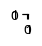

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn
import torch.nn.functional as F
import glob
# Here you import other functions and classes
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import encode_batch, AA_KEYS, BL62_VALUES, BL62FREQ_VALUES, HLAS, BL50, BL50_VALUES
from src.models import NNAlignEFSinglePass
from src.datasets import NNAlignDatasetEFSinglePass

In [3]:
# Note : I always name my notebooks with the day's date, with YYMMDD_descriptor.ipynb, and data / output the same way


# Here, a sample data just so that you can try playing around with the functions (that will have different columns from what you might have at the end)
df = pd.read_csv('../data/mhc1_el_sub10k/mhc1_el_subsampled.csv')
df.head()

,sequence,target,HLA,pseudoseq,partition
0,ELLKHQRMHTGHL,0.0,HLA-A01:01,DRQELLGHLPFD,0
1,KKDINNIVKTL,0.0,HLA-B15:01,DIRKKDKTLHEW,0
2,QVNGEAGSYEM,0.0,H-2-Dq,RKSQVNYEMTNQ,0
3,DVGELVGLGDVM,0.0,H-2-Kb,CAVDVGDVMDAL,0
4,RENPVVPIGCL,0.0,HLA-B51:01,RKTRENGCLATA,0


In [142]:
from src.data_processing import AA_KEYS

AA_KEYS

['A',
 'R',
 'N',
 'D',
 'C',
 'Q',
 'E',
 'G',
 'H',
 'I',
 'L',
 'K',
 'M',
 'F',
 'P',
 'S',
 'T',
 'W',
 'Y',
 'V']

In [143]:
df['flag'] = df['sequence'].apply(lambda x: any([z not in AA_KEYS for z in x]))
df.query('flag')

,sequence,target,HLA,pseudoseq,partition,len,flag
19510,ALLQASUYL,0.0,HLA-A02:01,TVVALLUYLCIL,1,9,True
49766,AUGYKPKYLQL,0.0,H-2-Db,YCGAUGLQLKEK,4,11,True


In [4]:
# Here, you can define the length of each sequence
df['len'] = df['sequence'].apply(len)
max_len = 13
window_size = 9

In [42]:
# Here, we can use "-" as the insert, with put 0s (though it is not the most correct technically)
encode_batch(['GILGF-FTL'], max_len=13, encoding='BL50LO', pad_scale=-20)

tensor([[[  0.,  -3.,   0.,  -1.,  -3.,  -2.,  -3.,   8.,  -2.,  -4.,  -4.,
           -2.,  -3.,  -4.,  -2.,   0.,  -2.,  -3.,  -3.,  -4.],
         [ -1.,  -4.,  -3.,  -4.,  -2.,  -3.,  -4.,  -4.,  -4.,   5.,   2.,
           -3.,   2.,   0.,  -3.,  -3.,  -1.,  -3.,  -1.,   4.],
         [ -2.,  -3.,  -4.,  -4.,  -2.,  -2.,  -3.,  -4.,  -3.,   2.,   5.,
           -3.,   3.,   1.,  -4.,  -3.,  -1.,  -2.,  -1.,   1.],
         [  0.,  -3.,   0.,  -1.,  -3.,  -2.,  -3.,   8.,  -2.,  -4.,  -4.,
           -2.,  -3.,  -4.,  -2.,   0.,  -2.,  -3.,  -3.,  -4.],
         [ -3.,  -3.,  -4.,  -5.,  -2.,  -4.,  -3.,  -4.,  -1.,   0.,   1.,
           -4.,   0.,   8.,  -4.,  -3.,  -2.,   1.,   4.,  -1.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [ -3.,  -3.,  -4.,  -5.,  -2.,  -4.,  -3.,  -4.,  -1.,   0.,   1.,
           -4.,   0.,   8.,  -4.,  -3.,  -2.,   1.,   4.,  -1.],
         [  0

In [47]:
from src.data_processing import encode, encode_batch
def do_insertion_deletion(sequence, max_len=13, encoding='BL50LO', pad_scale=-20, window_size=9):
    length = len(sequence)
    indel_windows = []

    # Insertion for sequences shorter than the window size
    if length < window_size:
        for i in range(window_size):
            indel_windows.append(sequence[:i] + '-' + sequence[i:])
        indel_windows.append('-'*9)    
    # Replicate sequence for sequences equal to the window size
    elif length == window_size:
        indel_windows = [sequence for _ in range(window_size)]
        indel_windows.append('-'*9) 
    # Deletion for sequences longer than the window size
    else:
        del_len = length - window_size
        for i in range(length - del_len + 1):
            indel_windows.append(sequence[:i] + sequence[i+del_len:])
            
    # Encoding the sequences
    encoded_sequences = encode_batch(indel_windows, max_len=max_len, encoding=encoding, pad_scale=pad_scale)
    print(indel_windows)
    return encoded_sequences
    
def batch_insertion_deletion(sequences, max_len=13, encoding='BL50LO', pad_scale=-20, window_size=9):
    # Process each sequence individually with do_insertion_deletion
    processed_sequences = [do_insertion_deletion(seq, max_len=max_len, encoding=encoding, pad_scale=pad_scale, window_size=window_size) for seq in sequences]
    
    # Stack the processed sequences along a new dimension to maintain the N x 9 x 13 x 20 structure
    # Ensure each do_insertion_deletion call returns a tensor of shape 9 x 13 x 20
    indel_windows_batch = torch.stack(processed_sequences)
    return indel_windows_batch
    
# Example usage:
sequences = ['GILGFVTL', 'GILGFVTLI', 'GILGFVTLIG', 'GILGFVTLIGF', 'GILGFVTLIGFT', 'GILGFVTLIGFTE']
results = batch_insertion_deletion(sequences, max_len = 13)

print(results.shape)

['-GILGFVTL', 'G-ILGFVTL', 'GI-LGFVTL', 'GIL-GFVTL', 'GILG-FVTL', 'GILGF-VTL', 'GILGFV-TL', 'GILGFVT-L', 'GILGFVTL-', '---------']
['GILGFVTLI', 'GILGFVTLI', 'GILGFVTLI', 'GILGFVTLI', 'GILGFVTLI', 'GILGFVTLI', 'GILGFVTLI', 'GILGFVTLI', 'GILGFVTLI', '---------']
['ILGFVTLIG', 'GLGFVTLIG', 'GIGFVTLIG', 'GILFVTLIG', 'GILGVTLIG', 'GILGFTLIG', 'GILGFVLIG', 'GILGFVTIG', 'GILGFVTLG', 'GILGFVTLI']
['LGFVTLIGF', 'GGFVTLIGF', 'GIFVTLIGF', 'GILVTLIGF', 'GILGTLIGF', 'GILGFLIGF', 'GILGFVIGF', 'GILGFVTGF', 'GILGFVTLF', 'GILGFVTLI']
['GFVTLIGFT', 'GFVTLIGFT', 'GIVTLIGFT', 'GILTLIGFT', 'GILGLIGFT', 'GILGFIGFT', 'GILGFVGFT', 'GILGFVTFT', 'GILGFVTLT', 'GILGFVTLI']
['FVTLIGFTE', 'GVTLIGFTE', 'GITLIGFTE', 'GILLIGFTE', 'GILGIGFTE', 'GILGFGFTE', 'GILGFVFTE', 'GILGFVTTE', 'GILGFVTLE', 'GILGFVTLI']
torch.Size([6, 10, 13, 20])


In [32]:
df.head(1)

,sequence,target,HLA,pseudoseq,partition,len
0,ELLKHQRMHTGHL,0.0,HLA-A01:01,DRQELLGHLPFD,0,13


In [65]:
max_len=13
window_size=9
x = encode_batch(sequences, max_len, 'BL50LO', -20)

# Creating the mask to allow selection of kmers without padding
x_mask = torch.from_numpy(np.array([len(x) for x in sequences])) - window_size
range_tensor = torch.arange(max_len - window_size + 1).unsqueeze(0).repeat(len(x), 1)
# Mask for Kmers + padding
x_mask = (range_tensor <= x_mask.unsqueeze(1)).float().unsqueeze(-1)

In [68]:
x_tensor = x.unfold(1, window_size, 1).transpose(2, 3) \
            .reshape(len(x), max_len - window_size + 1, window_size, 20)
x_flat = x_tensor.flatten(2, 3).contiguous()
x_tensor.shape, x_flat.shape, x_mask.shape

(torch.Size([6, 5, 9, 20]), torch.Size([6, 5, 180]), torch.Size([6, 5, 1]))

In [132]:
def create_indel_mask(length, window_size):
    mask = torch.zeros(1, window_size+1, 1)
    if length<window_size:
        mask[:, :-1, :].fill_(1)
    elif length==window_size:
        # Actually shouldn't fill with 1 because we are concatenating to the other mask
        # and only a single window (i.e. the first, un-concatenated one) is the correct one
        # mask[:, :1, :].fill_(1)
        pass
    elif length>window_size:
        mask.fill_(1)
    return mask

def batch_indel_mask(lengths, window_size):
    return torch.cat([create_indel_mask(length, window_size) for length in lengths], dim=0)

In [135]:
# Removing pad from the indel results
results = results[:,:,:window_size,:]
# Creating the mask
len_mask = [len(x) for x in sequences]
indel_mask = batch_indel_mask(len_mask, window_size)
indel_mask.shape

torch.Size([6, 10, 1])

In [141]:
# should concatenate results (x_indels) to x_tensor before flattening ?
# Also concatenate the indel_mask to x_mask the same way
results.shape, x_tensor.shape, results.flatten(2,3).shape, x_tensor.flatten(2,3).shape, torch.cat([x_tensor, results], axis=1).shape, torch.cat([x_tensor, results], axis=1).flatten(2,3).shape

(torch.Size([6, 10, 9, 20]),
 torch.Size([6, 5, 9, 20]),
 torch.Size([6, 10, 180]),
 torch.Size([6, 5, 180]),
 torch.Size([6, 15, 9, 20]),
 torch.Size([6, 15, 180]))